In [19]:
import pandas as pd
X_train=pd.read_csv('X_train1_scaled.csv')
X_val=pd.read_csv('X_val_scaled.csv')
X_test=pd.read_csv('X_test_scaled.csv')
y_test=pd.read_csv('y_test.csv')
y_train=pd.read_csv('y_train_ml_stat.csv')
y_val=pd.read_csv('y_val.csv')
train_data = pd.concat([X_train, y_train], axis=1)


val_data = pd.concat([X_val, y_val], axis=1)


test_data = pd.concat([X_test, y_test], axis=1)

In [20]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

In [21]:
num_bins = 2  
labels = [f'bin_{i}' for i in range(1, num_bins + 1)]

train_data['Monthly_Charges_Discrete'] = pd.cut(
    train_data['Monthly_Charges'], bins=num_bins, labels=labels
)

In [22]:
num_bins = 2  
labels = [f'bin_{i}' for i in range(1, num_bins + 1)]

val_data['Monthly_Charges_Discrete'] = pd.cut(
    val_data['Monthly_Charges'], bins=num_bins, labels=labels
)

In [23]:
num_bins = 2  
labels = [f'bin_{i}' for i in range(1, num_bins + 1)]

test_data['Monthly_Charges_Discrete'] = pd.cut(
    test_data['Monthly_Charges'], bins=num_bins, labels=labels
)

In [24]:
b_model2 = BayesianModel([
    ('Payment_Method_Electronic_check', 'Streaming_TV_Yes', 'Internet_Service_Fiber_optic', 'Churn_Value'),
    ('Churn_Value', 'Streaming_TV_Yes', 'Tech_Support_No'),
    ('Churn_Value', 'Tech_Support_No'),
    ('Churn_Value', 'Online_Backup_No'),
    ('Churn_Value', 'Online_Security_No', 'Online_Backup_No'),
    ('Internet_Service_Fiber_optic', 'Churn_Value'),
    ('Churn_Value', 'Multiple_Lines_Yes'),
    ('Dependents_No', 'Churn_Value'),
    ('Paperless_Billing_Yes', 'Churn_Value'),
    ('Monthly_Charges_Discrete', 'Churn_Value'),  
    ('Monthly_Charges_Discrete', 'Paperless_Billing_Yes', 'Churn_Value'),  
    ('Churn_Value', 'Contract_Month_to_month')
])

b_model2.fit(train_data, estimator=MaximumLikelihoodEstimator)

C:\Users\HP\anaconda3\envs\Work\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


In [25]:
from pgmpy.inference import VariableElimination

churn_infer=VariableElimination(b_model2)
q1=churn_infer.query(variables=['Churn_Value'],evidence={'Internet_Service_Fiber_optic': 0}, joint=False)
print(q1['Churn_Value'])

+----------------+--------------------+
| Churn_Value    |   phi(Churn_Value) |
+================+====================+
| Churn_Value(0) |             0.7409 |
+----------------+--------------------+
| Churn_Value(1) |             0.2591 |
+----------------+--------------------+


C:\Users\HP\anaconda3\envs\Work\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


In [26]:
churn_infer=VariableElimination(b_model2)
q2=churn_infer.query(variables=['Churn_Value'],evidence={'Internet_Service_Fiber_optic': 1}, joint=False)
print(q2['Churn_Value'])

+----------------+--------------------+
| Churn_Value    |   phi(Churn_Value) |
+================+====================+
| Churn_Value(0) |             0.2555 |
+----------------+--------------------+
| Churn_Value(1) |             0.7445 |
+----------------+--------------------+


In [27]:
inference = VariableElimination(b_model2)
print(inference)

In [28]:
predicted_probabilities = []
for index, row in val_data.iterrows():
    evidence = {'Payment_Method_Electronic_check': row['Payment_Method_Electronic_check'], 
                'Streaming_TV_Yes': row['Streaming_TV_Yes'],
                'Internet_Service_Fiber_optic': row['Internet_Service_Fiber_optic'],
                'Monthly_Charges_Discrete': row['Monthly_Charges_Discrete'],
                'Tech_Support_No': row['Tech_Support_No'],
                'Online_Backup_No': row['Online_Backup_No'],
                'Online_Security_No': row['Online_Security_No'],
                'Multiple_Lines_Yes': row['Multiple_Lines_Yes'],
                'Dependents_No': row['Dependents_No'],
                'Paperless_Billing_Yes': row['Paperless_Billing_Yes'],
                
                'Contract_Month_to_month': row['Contract_Month_to_month']}
    probability = inference.query(variables=['Churn_Value'], evidence=evidence)
    predicted_probabilities.append(probability.values)

predicted_probabilities_df1 = pd.DataFrame(predicted_probabilities, columns=['P(C=0)', 'P(C=1)'])

print(predicted_probabilities_df1)

        P(C=0)    P(C=1)
0     0.986107  0.013893
1     0.997691  0.002309
2     0.024188  0.975812
3     0.978474  0.021526
4     0.876661  0.123339
...        ...       ...
1122  0.987769  0.012231
1123  0.424242  0.575758
1124  0.887101  0.112899
1125  0.974224  0.025776
1126  0.072200  0.927800

[1127 rows x 2 columns]


In [29]:
predicted_probabilities_df1['Churn_Value'] = predicted_probabilities_df1.apply(lambda row: 0 if row['P(C=0)'] >= row['P(C=1)'] else 1, axis=1)

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(predicted_probabilities_df1['Churn_Value'],val_data['Churn_Value'])

0.7302573203194321

In [31]:
from sklearn.metrics import f1_score
f1_score(predicted_probabilities_df1['Churn_Value'],val_data['Churn_Value'],average=None)

array([0.7997365 , 0.58695652])

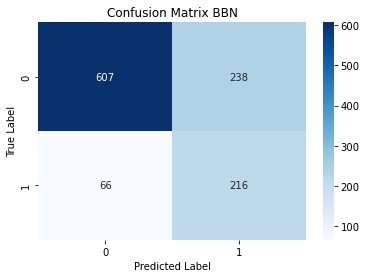

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_val, predicted_probabilities_df1['Churn_Value'])

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix BBN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.savefig('cm_bbn.png')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(predicted_probabilities_df1['Churn_Value'],val_data['Churn_Value'])

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve



fpr, tpr, thresholds = roc_curve(val_data['Churn_Value'], predicted_probabilities_df1['Churn_Value'])

# Calculate AUC score
auc_score = roc_auc_score(val_data['Churn_Value'], predicted_probabilities_df1['Churn_Value'])

# Plot ROC curve
plt.plot(fpr, tpr, label=f'BBN Regression (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_BBN')
plt.legend()
plt.savefig('roc_bbn.png')
plt.show()

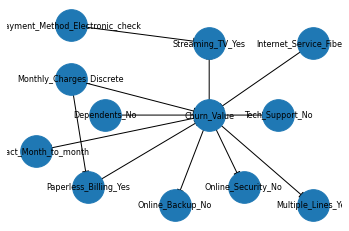

In [15]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(b_model2.nodes())
G.add_edges_from(b_model2.edges())

pos = {
    'Payment_Method_Electronic_check': (-1, 3.5),
    'Streaming_TV_Yes': (3, 3),
    'Internet_Service_Fiber_optic': (6, 3),
    'Churn_Value': (3, 1),
    'Tech_Support_No': (5, 1),
    'Online_Backup_No': (2, -1.5),
    'Online_Security_No': (4, -1),
    'Multiple_Lines_Yes': (6, -1.5),
    'Dependents_No': (0, 1),
    'Paperless_Billing_Yes': (-0.5, -1),
    'Monthly_Charges_Discrete': (-1, 2),
    'Contract_Month_to_month': (-2, 0)
}

# Draw the BBN diagram using networkx and matplotlib
nx.draw_networkx_nodes(G, pos, node_size=1000)
nx.draw_networkx_edges(G, pos, arrowsize=15, width=1)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
plt.axis('off')
plt.savefig('bbn.png')
plt.show()

In [17]:
import pandas as pd

# Calculate predicted probabilities for train_data
predicted_probabilities_train = []
for index, row in train_data.iterrows():
    evidence = {'Payment_Method_Electronic_check': row['Payment_Method_Electronic_check'], 
                'Streaming_TV_Yes': row['Streaming_TV_Yes'],
                'Internet_Service_Fiber_optic': row['Internet_Service_Fiber_optic'],
                'Monthly_Charges_Discrete': row['Monthly_Charges_Discrete'],
                'Tech_Support_No': row['Tech_Support_No'],
                'Online_Backup_No': row['Online_Backup_No'],
                'Online_Security_No': row['Online_Security_No'],
                'Multiple_Lines_Yes': row['Multiple_Lines_Yes'],
                'Dependents_No': row['Dependents_No'],
                'Paperless_Billing_Yes': row['Paperless_Billing_Yes'],
                'Contract_Month_to_month': row['Contract_Month_to_month']}
    probability = inference.query(variables=['Churn_Value'], evidence=evidence)
    predicted_probabilities_train.append(probability.values)

predicted_probabilities_train_df = pd.DataFrame(predicted_probabilities_train, columns=['P(C=0)', 'P(C=1)'])
print("Predicted probabilities for train_data:")
print(predicted_probabilities_train_df)

predicted_probabilities_train_df['Churn_Value'] = predicted_probabilities_train_df.apply(lambda row: 0 if row['P(C=0)'] >= row['P(C=1)'] else 1, axis=1)

from sklearn.metrics import accuracy_score
accuracy_score(predicted_probabilities_train_df['Churn_Value'],train_data['Churn_Value'])

C:\Users\HP\anaconda3\envs\Work\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


Predicted probabilities for train_data:
        P(C=0)    P(C=1)
0     0.024760  0.975240
1     0.109534  0.890466
2     0.079069  0.920931
3     0.947050  0.052950
4     0.983511  0.016489
...        ...       ...
6635  0.066894  0.933106
6636  0.534580  0.465420
6637  0.064567  0.935433
6638  0.524007  0.475993
6639  0.022802  0.977198

[6640 rows x 2 columns]


0.7564759036144578

In [18]:
# Calculate predicted probabilities for test_data
predicted_probabilities_test = []
for index, row in test_data.iterrows():
    evidence = {'Payment_Method_Electronic_check': row['Payment_Method_Electronic_check'], 
                'Streaming_TV_Yes': row['Streaming_TV_Yes'],
                'Internet_Service_Fiber_optic': row['Internet_Service_Fiber_optic'],
                'Monthly_Charges_Discrete': row['Monthly_Charges_Discrete'],
                'Tech_Support_No': row['Tech_Support_No'],
                'Online_Backup_No': row['Online_Backup_No'],
                'Online_Security_No': row['Online_Security_No'],
                'Multiple_Lines_Yes': row['Multiple_Lines_Yes'],
                'Dependents_No': row['Dependents_No'],
                'Paperless_Billing_Yes': row['Paperless_Billing_Yes'],
                'Contract_Month_to_month': row['Contract_Month_to_month']}
    probability = inference.query(variables=['Churn_Value'], evidence=evidence)
    predicted_probabilities_test.append(probability.values)

predicted_probabilities_test_df = pd.DataFrame(predicted_probabilities_test, columns=['P(C=0)', 'P(C=1)'])
print("Predicted probabilities for test_data:")
print(predicted_probabilities_test_df)

predicted_probabilities_test_df['Churn_Value'] = predicted_probabilities_test_df.apply(lambda row: 0 if row['P(C=0)'] >= row['P(C=1)'] else 1, axis=1)

from sklearn.metrics import accuracy_score
accuracy_score(predicted_probabilities_test_df['Churn_Value'],test_data['Churn_Value'])

C:\Users\HP\anaconda3\envs\Work\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


Predicted probabilities for test_data:
        P(C=0)    P(C=1)
0     0.086346  0.913654
1     0.351532  0.648468
2     0.887101  0.112899
3     0.077343  0.922657
4     0.131211  0.868789
...        ...       ...
1404  0.870391  0.129609
1405  0.022802  0.977198
1406  0.447028  0.552972
1407  0.974383  0.025617
1408  0.066894  0.933106

[1409 rows x 2 columns]


0.7331440738112136